## Same thing but in pytorch

In [106]:
import torch
import random
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [107]:
# by default would be float
# by default asumes it doesnt require grad

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
bias = torch.Tensor([6.8813735870195432]).double()  ; bias.requires_grad = True
n = x1*w1 + x2*w2 + bias
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [108]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

### Just getting our old code

In [109]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __neg__(self): return self * -1
    def __sub__(self, other): return self + (-other)
    def __radd__(self, other): return self + other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


from graphviz import Digraph
#https://graphviz.org/

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# And, let's train a Neural Network 🤖

<img src="neuron_model.jpeg" width="600">

In [110]:
class Neuron:
    """A single neuron in a neural network implementing wx + b followed by tanh activation"""
    
    def __init__(self, n_inputs):
        # Initialize weights and bias with random values between -1 and 1
        self.weights = [Value(random.uniform(-1,1)) for _ in range(n_inputs)]
        self.bias = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # Forward pass: compute weighted sum (wx + b) and apply tanh activation
        # this will be called when . n=Neuron(2); n(x)-->__call__
        act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        # Return all trainable parameters (weights and bias)
        return self.weights + [self.bias]


<img src="layer.jpg" width="600">

In [111]:
class Layer:
    """A layer of neurons that transforms input vector to output vector"""
    
    def __init__(self, n_inputs, n_outputs):
        # Create n_outputs neurons, each taking n_inputs inputs
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
    
    def __call__(self, x):
        # Forward pass: compute outputs for all neurons
        # Special case: return scalar for single-neuron layers
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # Collect parameters from all neurons in the layer
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [112]:
class MLP:
    """Multi-Layer Perceptron - a fully connected feedforward neural network"""
    
    def __init__(self, n_inputs, n_outputs):
        # Create layers with sizes [nin, nouts[0], nouts[1], ...]
        sz = [n_inputs] + n_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outputs))]
    
    def __call__(self, x):
        # Forward pass: propagate input through all layers sequentially
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # Collect parameters from all layers in the network
        return [p for layer in self.layers for p in layer.parameters()]

In [113]:

x = [2.0, 3.0, -1.0]
#3 inputs, 3 layers of 4,4 and 1 output
nn = MLP(3, [4, 4, 1])

nn(x)

Value(data=-0.7050148014358326)

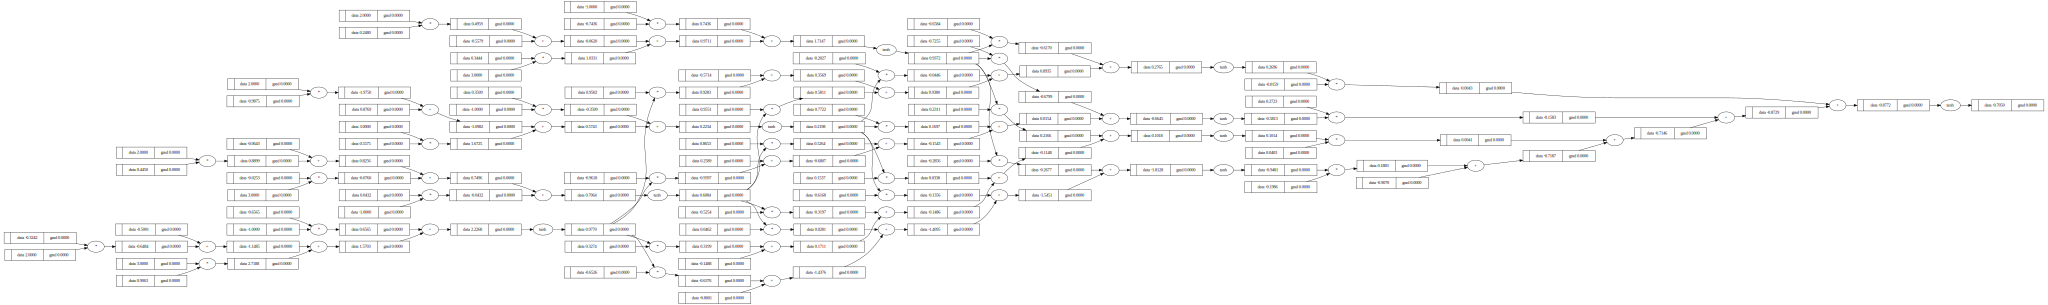

In [114]:
draw_dot(nn(x)) #shits gettin real

## Train our neural network

In [115]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets (binary classifier)

y_groundtruth= ys

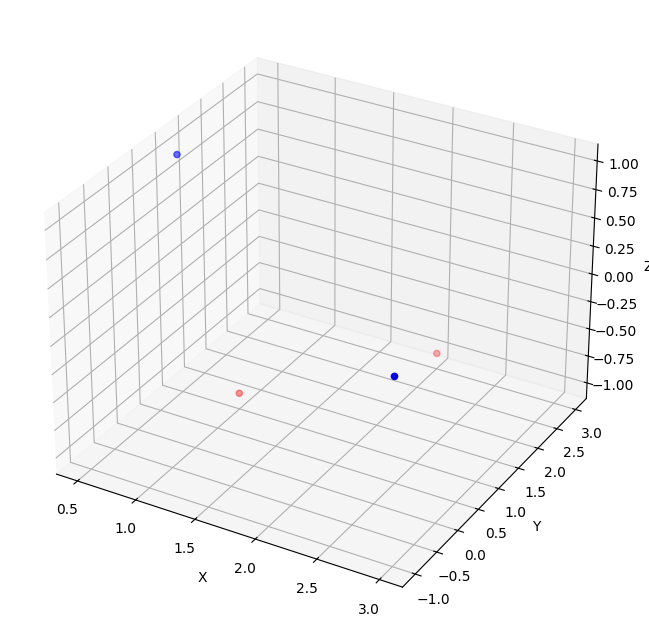

In [116]:
#Showing. 1=red, -1=blue

xs = np.array(xs)
colors = ['red' if y == 1 else 'blue' for y in ys]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=colors)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [117]:
#without training...

y_bad_pred =[nn(x) for x in xs]

print(y_bad_pred)
print("vs.")
print(y_groundtruth)


[Value(data=-0.7050148014358326), Value(data=-0.6641934639052246), Value(data=-0.4729292061477041), Value(data=-0.6894189052473657)]
vs.
[1.0, -1.0, -1.0, 1.0]


In [118]:
# We'll use MSE to calculate the loss (how well/bad is the nn performing the task)
# We need to minimize the loss. For that we backpropagate a see wich weights can reduce the loss

loss= sum((ybp-ygt)**2 for ygt, ybp in zip(y_groundtruth,y_bad_pred))
loss

#we could do loss.backward()

Value(data=6.151781361938541)

In [119]:
# All the weights and biases
print(f"{len(nn.parameters())} parameters")
nn.parameters()

41 parameters


[Value(data=-0.32420065184336266),
 Value(data=0.906251951441855),
 Value(data=-0.6565160279073587),
 Value(data=-0.5000794724736919),
 Value(data=0.44496901021065893),
 Value(data=-0.02534846645085076),
 Value(data=0.04316556109016001),
 Value(data=-0.06433710321940311),
 Value(data=-0.98752207789307),
 Value(data=0.5574898815911247),
 Value(data=0.35087180472197765),
 Value(data=0.876889874674319),
 Value(data=0.2479509225194254),
 Value(data=0.3443536318181304),
 Value(data=-0.743586217553059),
 Value(data=-0.5578602894932099),
 Value(data=-0.6525653838038388),
 Value(data=0.046236635952494165),
 Value(data=-0.6168116462111468),
 Value(data=-0.2856444076080771),
 Value(data=-0.8000911018085282),
 Value(data=0.3273878242552217),
 Value(data=-0.5254005630259921),
 Value(data=0.1537153533772373),
 Value(data=0.23109553526879334),
 Value(data=-0.14877809737812897),
 Value(data=-0.961791413221414),
 Value(data=0.8652782592962884),
 Value(data=0.7721726179097621),
 Value(data=-0.725482865

In [ ]:
#The actual train

loss_history = []

for k in range(2000):#number of epochs
    # Forward pass - compute predictions and loss
    ypred = [nn(x) for x in xs]
    loss = sum((yout - y_groundtruth)**2 for y_groundtruth, yout in zip(ys, ypred))
    
    # Store loss for plotting
    loss_history.append(loss.data)
    
    # Reset gradients before backward pass
    for p in nn.parameters():
        p.grad = 0.0
    
    # Backward pass - compute gradients
    loss.backward()
    
    # Gradient descent update with **learning rate** 0.01
    for p in nn.parameters():
        p.data += -0.01 * p.grad
    #if lr is to low it will train very slow
    #if lr is to high it gets unstable
    print(k, loss.data)
  

0 6.151781361938541
1 5.858802717123645
2 5.534338853738337
3 5.182824173905072
4 4.812403772196185
5 4.433841723566935
6 4.0588818532222515
7 3.6986255238677055
8 3.3621389510231614
9 3.055400079710825
10 2.780854206548445
11 2.537763588234091
12 2.3231696658424275
13 2.13303304039696
14 1.9631742360455182
15 1.8098603428176077
16 1.6700656282057387
17 1.5415087246149293
18 1.4225672393168303
19 1.3121413809283458
20 1.209509338932364
21 1.1141969593622507
22 1.0258719390373634
23 0.9442655112803592
24 0.8691202779850924
25 0.8001603305490554
26 0.7370785914833253
27 0.6795361101960828
28 0.6271685781737738
29 0.5795962822270802
30 0.5364348034049278
31 0.4973047807995742
32 0.4618398743389014
33 0.42969264162160004
34 0.40053840897833926
35 0.37407741143793205
36 0.3500355514058187
37 0.328164126858151
38 0.3082388411224585
39 0.2900583511792618
40 0.27344255404261286
41 0.2582307586863589
42 0.24427984736185443
43 0.2314624956210169
44 0.21966549419377857
45 0.20878819677934807
46 0

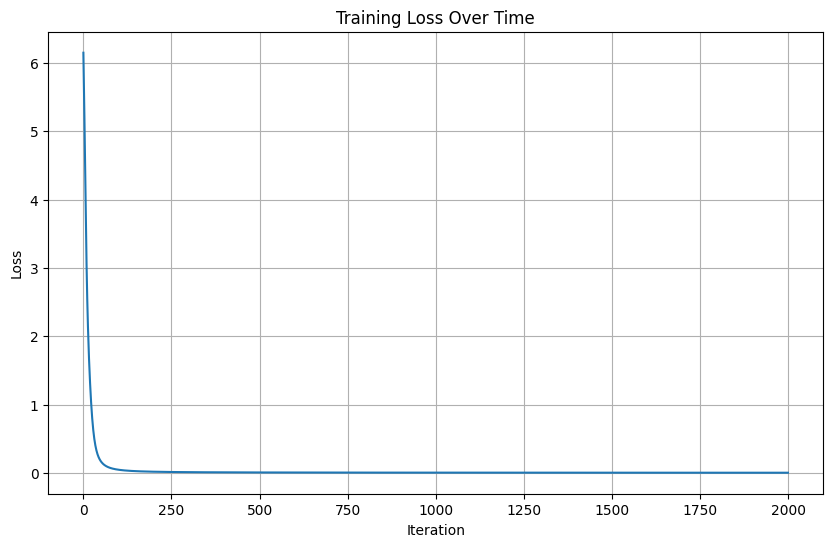

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

In [122]:
#See how it predicts now


y_good_pred =[nn(x) for x in xs]

print(y_good_pred)
print("vs.")
print(y_groundtruth)

[Value(data=0.9871577184838036), Value(data=-0.991640451918764), Value(data=-0.9822979745572806), Value(data=0.9782147698167367)]
vs.
[1.0, -1.0, -1.0, 1.0]
